- Load necessary module

In [21]:
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import multinomial
from collections import OrderedDict

- Load model that defined in channel realization

In [40]:
np.random.seed(1)
mat = io.loadmat('temp.mat')
model = {}
model['H'] = mat['H']
model['Wopt'] = mat['Wopt']
model['Fopt'] = mat['Fopt']
model['Ns'] = mat['Ns'][0,0] ## need to change nb of stream in channel realization, this case 1
# model['Ns'] = 2
model['Nt'] = mat['Nt'][0,0]
model['Nr'] = mat['Nr'][0,0]
model['Nc'] = mat['Nc'][0,0]
model['Nray'] = mat['Nray'][0,0]
model['realization'] = mat['realization'][0,0]
model['At'] = mat['At']
model['Ar'] = mat['Ar']
model['Nrf'] = 2
archi = 'FC'

In [23]:
for key in model:
    print(key)

H
Wopt
Fopt
Ns
Nt
Nr
Nc
Nray
realization
At
Ar
Nrf


Load values of phase shifter included:
- nb_bit: number of bit
- nb_ps: number of phase shifter in the system
- nb_state: number of state in each phase shifter (2^nb_bit)

# Cross Entropy Beamforming

### Helper function for Cross entropy Beamforming

In [24]:
def phase_shifter(n_bit,n_ant):
    """
    Define phase shifter with N bits resolution
    
    Arguments:
    N -- number of bits resolutions
    
    Returns:
    y -- python dictionnary of phase shifter: index of state and value of phase
    """
    nb_state = 2**n_bit
    w = np.exp(1j*2*np.pi/nb_state)
    ps = np.zeros(nb_state,dtype=complex)
    for i in range(nb_state):
        ps[i] = w**i/np.sqrt(n_ant)
    return np.around(ps, decimals=3)

def generate_candidat(S,model,phase_value,ps_system_proba,archi):
    """
    generate S candidates from the previous pmf
    
    Arguments: 
    S -- Number of candidates to generate
    model -- channel model
    phase_value -- possible phase shifted value
    ps_system_proba -- pmf of phase shifters
    
    Returns
    F_rf -- S analog precoder system
    """
    F_rf = np.zeros((S,model['Nt'],model['Nrf']),dtype=complex)
    if archi == 'FC':
        for i in range(S):
            for j in range(model['Nt']):
                for k in range(model['Nrf']):
                    F_rf[i,j,k] = np.random.choice(phase_value, 1, p=ps_system_proba[j,k,:])
    if archi == 'PC':
        only_PS = np.zeros((S,model['Nt']),dtype=complex)
        m = int(model['Nt']/model['Nrf'])
        for i in range(S):
            for j in range(model['Nt']):
                only_PS[i,j] = np.random.choice(phase_value, 1, p=ps_system_proba[j,:])
            for k in range(model['Nrf']):
                F_rf[i,k*m:(k+1)*m,k] = only_PS[i,k*m:(k+1)*m]
    return F_rf

def compute_Fbb(F_rf,model,channel):
    """
    Compute baseband precoder base on the effective channel (Heq = H*Frf)
    
    Arguments:
    F_rf -- analog precoder
    model -- channel model
    
    Returns:
    F_bb -- S baseband precoder
    """
    S = F_rf.shape[0]
    channel_eq = np.zeros((S,model['Nr'],model['Nrf']),dtype=complex)
    F_bb = np.zeros((S,model['Nrf'],model['Ns']),dtype=complex)
#     channel_index = 0 ### need to adjust 
    for i in range(S):
        channel_eq[i,:,:] =  channel@F_rf[i,:,:]
        U, s, V = np.linalg.svd(channel_eq[i,:,:], full_matrices=True)
        V = V.conj().T
        F_bb[i,:,:] = V[0:model['Nt'],0:model['Ns']]
        F_bb[i,:,:] = np.sqrt(model['Ns'])*F_bb[i,:,:]/np.linalg.norm(F_rf[i,:,:]@F_bb[i,:,:],'fro')
    return F_bb

def optimal_beamformer(model, channel):
    """
    Compute the optimal beamformer by SVD
    
    Arguments:
    model -- channel model
    channel_index -- index in 1000 realization channel
    
    Returns:
    Fopt -- optimal precoder
    Wopt -- optimal combiner
    """
    Wopt = np.zeros((model['Nr'],model['Ns']),dtype=complex)
    Fopt = np.zeros((model['Nt'],model['Ns']),dtype=complex)
    U, s, V = np.linalg.svd(channel, full_matrices=True)
    V = V.conj().T
    Fopt = V[0:model['Nt'],0:model['Ns']]
    Wopt = U[0:model['Nr'],0:model['Ns']]
    return Fopt, Wopt


def update_pmf(F_elites,phase_value,nb_elite,R_elite,ps_system_proba,archi):
    """
    Update new phase shifters's pmf base on previous candidates's results
    
    Arguments:
    F_elites -- elites analog precoder
    phase_value -- phase shift value
    nb_elite -- number of elites 
    
    Returns:
    ps_system_proba -- pmf of phase shifter
    """
    alpha = 0.9
    nb_state = phase_value.shape[0]
    stat_count = np.zeros(nb_state)
    assign = np.zeros(nb_elite)
    weight = R_elite/np.mean(R_elite)
    if archi == 'FC':
        for i in range(model['Nt']):
            for j in range(model['Nrf']):
                for k in range(nb_state):
                    assign = F_elites[:,i,j] == phase_value[k]
    #                 proba_est = np.sum(assign*weight)/nb_elite
                    proba_est = np.sum(assign)/nb_elite
                    ps_system_proba[i,j,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,j,k] 
    if archi == 'PC':
        for i in range(model['Nt']):
            for k in range(nb_state):
                assign = F_elites[:,i] == phase_value[k]
    #                 proba_est = np.sum(assign*weight)/nb_elite
                proba_est = np.sum(assign)/nb_elite
                ps_system_proba[i,k] = alpha*proba_est + (1-alpha)*ps_system_proba[i,k]   
    return ps_system_proba

def data_rate(Ns,SNR,W,H,F):
    """
    Compute the data rate of the beamforming system
    
    Arguments:
    Ns -- number of stream
    SNR -- Signal to noise ratio
    W -- combiner
    H -- channel
    F -- precoder
    
    Returns:
    R -- data rate
    """
    R = np.log2(np.linalg.det(np.eye(Ns)+SNR/Ns*np.linalg.pinv(W)@H@F@F.conj().T@H.conj().T@W))
    return R.real

### Define Phase shiter

In [25]:
nb_bit = 2
nb_ps = model['Nt']*model['Nrf']
nb_ps
nb_state = 2**nb_bit

In [26]:
phase_value = phase_shifter(nb_bit,model['Nt'])
phase_value

array([ 0.125+0.   j,  0.   +0.125j, -0.125+0.   j, -0.   -0.125j])

Phase shifter system dimension is: NtxNrfxN_state

### Cross entropy beamforming Algorithm
 Step 1: Randomly generate S candidate analog beamformers

 Step 2: Compute S corresponding digital precoders Fbb based on the effective channel Heq = HFrf

 Step 3: Calculate the achievable sum-rate

 Step 4: Sort R in a descend order

 Step 5: Select elites as Frf_1, Frf_2, ..., Frf_elite

 Step 6: Update new pmf for each phase shifter

In [7]:
# channel_index = 0
# model['Fopt'], model['Wopt'] = optimal_beamformer(model,channel_index)


In [73]:
def CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,SNR,archi):
    """
    Hybrid beamforming by Cross-entropy method
    
    """
    Fopt, Wopt = model['Fopt'][:,:,channel_index],model['Wopt'][:,:,channel_index]
    if archi == 'FC':
        ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
#         proba_evo = np.copy(ps_system_proba[0,0,:])
    elif archi == 'PC':
        ps_system_proba = np.ones((model['Nt'],nb_state))*(1/nb_state)
#         proba_evo = np.copy(ps_system_proba[0,:])
#     print(ps_system_proba)
    relative_std = 1000 # initialize high value of relative standard deviation
    i = 0
    while ((i<nb_iterate) and (relative_std>3)):
#         print(i)
        F_rf = generate_candidat(S,model,phase_value,ps_system_proba,archi)
        F_bb = compute_Fbb(F_rf,model,model['H'][:,:,channel_index])
        R = np.zeros((S))
        for j in range(S):
            R[j] = data_rate(model['Ns'],SNR,Wopt,model['H'][:,:,channel_index],F_rf[j,:,:]@F_bb[j,:,:])
        R_sort_index = np.argsort(R)[::-1][:nb_elite]
        if i==0:
            R_max = R[R_sort_index[0]]
        else:
            R_max = np.append(R_max,R[R_sort_index[0]])
        F_elites = F_rf[R_sort_index,:,:]
        Frf_max = F_rf[R_sort_index[0],:,:]
        Fbb_max = F_bb[R_sort_index[0],:,:]
        ps_system_proba = update_pmf(F_elites,phase_value,nb_elite,R[R_sort_index],ps_system_proba,archi)
#         if archi == 'FC':
#             proba_evo = np.vstack((proba_evo,ps_system_proba[0,0,:]))
#         elif archi == 'PC':
#             proba_evo = np.vstack((proba_evo,ps_system_proba[0,:]))
        if i>=5:
            R_max_normalize = R_max-np.min(R_max) ## Need to review
            relative_std = 100*np.std(R_max_normalize[i-5:i])/np.mean(R_max_normalize[i-5:i])
#             print(relative_std)
        i +=1
    output = {}
    output['R_max'] = R_max
    output['Frf_max'] = Frf_max
    output['Fbb_max'] = Fbb_max
    output['nb_ite'] = i
#     output['proba_evo'] = proba_evo
    output['ps_system_proba'] = ps_system_proba
    return output

In [161]:
nb_elite = 40
S = 200
channel_index = 0
nb_iterate = 30
# if archi == 'FC':
#     ps_system_proba = np.ones((model['Nt'],model['Nrf'],nb_state))*(1/nb_state)
# elif archi == 'PC':
#     ps_system_proba = np.ones((model['Nt'],nb_state))*(1/nb_state)
SNR_dB = np.arange(-30,15,5)
# SNR = 10**(SNR_dB/10)
# SNR = 10**(10/10)
# smax = SNR.shape[0]

In [95]:
data_rate(model['Ns'],10**(10/10),model['Wopt'][:,:,0],model['H'][:,:,channel_index],test['Frf_max']@test['Fbb_max'])

11.572286579376094

In [162]:
SNR_dB

array([-30, -25, -20, -15, -10,  -5,   0,   5,  10])

In [75]:
test['R_max']

array([ 9.00061469,  9.11674506,  9.19418111,  9.43042221,  9.83057727,
        9.94216701, 10.32700815, 10.57002158, 10.78025141, 10.83176591,
       11.04114858, 11.16978164, 11.29842888, 11.37502188, 11.4456515 ,
       11.50933022, 11.5591301 , 11.56912152, 11.57228658])

In [74]:
test = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,0,SNR,'PC')

In [159]:
rate_CE_PC = np.zeros((SNR_dB.shape[0]))
sum_rate_CE_PC = np.zeros((SNR_dB.shape[0]))
for channel_index in range(5):
    print('index: ' + str(channel_index))
    CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,10**(10/10),'PC')
    for i in range(SNR_dB.shape[0]):
        rate_CE_PC[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],CE_result['Frf_max']@CE_result['Fbb_max'])
    sum_rate_CE_PC = sum_rate_CE_PC + rate_CE_PC
    print(rate_CE_PC)

index: 0
[0.12987122 0.37615032 0.95751369 1.9923116  3.38122836 4.94426809
 6.57282946 8.22339355 9.88105318]
index: 1
[0.07554852 0.22651977 0.62069529 1.43300813 2.67268792 4.16999809
 5.7750928  7.41792945 9.07311338]
index: 2
[0.13257368 0.38334391 0.97267501 2.01564613 3.40935835 4.97435326
 6.60359075 8.25437501 9.91210492]
index: 3
[0.10120705 0.29842895 0.78802206 1.72161093 3.04737353 4.58378661
 6.20301616 7.85052732 9.50721095]
index: 4
[0.10800277 0.31709602 0.82972955 1.7900227  3.13315602 4.67705903
 6.29893713 7.94731744 9.60427921]


In [ ]:
rate_CE_FC = np.zeros((SNR_dB.shape[0]))
sum_rate_CE_FC = np.zeros((SNR_dB.shape[0]))
for channel_index in range(5):
    print('index: ' + str(channel_index))
    CE_result = CE_beamforming(nb_elite,S,nb_iterate,model,nb_bit,nb_state,channel_index,10**(10/10),'FC')
    for i in range(SNR_dB.shape[0]):
        rate_CE_FC[i] = data_rate(model['Ns'],10**(SNR_dB[i]/10),model['Wopt'][:,:,channel_index],model['H'][:,:,channel_index],CE_result['Frf_max']@CE_result['Fbb_max'])
    sum_rate_CE_FC = sum_rate_CE_FC + sum_rate_CE_FC
    print(rate_CE_FC)

index: 0
[ 0.38554521  0.97729785  2.02273491  3.41788553  4.98346512  6.61290455
  8.26375455  9.92150545 11.58145192]
index: 1
[ 0.25445995  0.68703286  1.55035459  2.82775593  4.34261958  5.95412405
  7.59908802  9.25495525 10.91430378]
index: 2
[ 0.45156309  1.11250249  2.22503148  3.65787293  5.23848538  6.87307957
  8.52560342 10.18388813 11.84400386]
index: 3


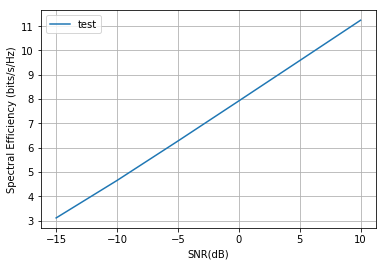

In [150]:
plt.plot(SNR_dB, sum_rate_CE/5, label='test')
plt.legend(loc='upper left')
plt.xlabel('SNR(dB)')
plt.ylabel('Spectral Efficiency (bits/s/Hz)')
plt.grid()
plt.show()

In [15]:
# Evolution of pmf of 1 phase shifter
np.around(CE_result['ps_system_proba'], decimals=3)

array([[0.15 , 0.795, 0.   , 0.056],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.001, 0.999],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.083, 0.359, 0.558],
       [0.   , 1.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.439, 0.561],
       [0.   , 0.   , 1.   , 0.   ],
       [0.   , 0.07 , 0.93 , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.016, 0.984, 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.123, 0.   , 0.005, 0.872],
       [0.   , 0.   , 0.84 , 0.16 ],
       [0.   , 1.   , 0.   , 0.   ],
       [0.001, 0.999, 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.004, 0.996, 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.972, 0.028, 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 1.   , 0.   ],
 

Data rate evolution: [12.23867096 12.27597053 13.17645162 14.11500101 14.47453745 15.16455224
 15.58488354 15.97411588 16.37816747 16.63764473 16.95175092 17.05461886
 17.22186491 17.25692882 17.36881351 17.4355577  17.47026738]
Number of iteration: 17
Phase shifter pmf[[0.25  0.25  0.25  0.25 ]
 [0.318 0.205 0.25  0.228]
 [0.279 0.2   0.205 0.315]
 [0.253 0.2   0.156 0.392]
 [0.205 0.2   0.218 0.377]
 [0.178 0.245 0.112 0.465]
 [0.243 0.407 0.079 0.272]
 [0.227 0.423 0.098 0.252]
 [0.248 0.38  0.077 0.295]
 [0.227 0.465 0.03  0.277]
 [0.18  0.497 0.026 0.298]
 [0.153 0.612 0.003 0.232]
 [0.173 0.624 0.    0.203]
 [0.13  0.715 0.    0.155]
 [0.103 0.701 0.    0.196]
 [0.1   0.745 0.    0.155]
 [0.145 0.75  0.    0.105]
 [0.15  0.795 0.    0.056]]


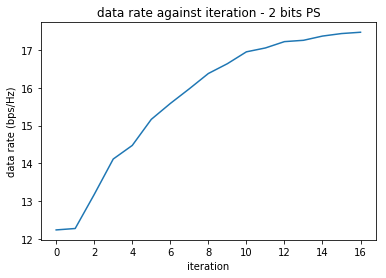

In [16]:
print('Data rate evolution: ' + str(CE_result['R_max']))
plt.plot(CE_result['R_max'])
plt.title('data rate against iteration - 2 bits PS')
plt.ylabel('data rate (bps/Hz)')
plt.xlabel('iteration')
print('Number of iteration: ' + str(CE_result['nb_ite']))
print('Phase shifter pmf' + str(np.around(CE_result['proba_evo'], decimals=3)))

Test:

2 bits -- 17.56 bps/Hz - 16 iterate

3 bits -- 17.68 bps/Hz - 18 iterate

4 bits -- 17.71 bps/Hz - 18 iterate

6 bits -- 17.68 bps/Hz - 19 iterate

# Digital Beamforming

In [17]:
CE_result['proba_evo'].shape

(18, 4)

In [18]:
R_o = data_rate(model['Ns'],SNR,model['Wopt'],model['H'][:,:,channel_index],model['Fopt'])
print('Data rate by digital beamforming: ' + str(R_o))

Data rate by digital beamforming: 20.272395739424006


In [19]:
# Normalize condition
x = np.linalg.norm(CE_result['Frf_max']@CE_result['Fbb_max'],'fro')
print("Ns", model['Ns'] , "   Frobenius norm FRF*FBB=", x**2)

Ns 2    Frobenius norm FRF*FBB= 2.000000000000001
